In [8]:
import os
import tqdm
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
%matplotlib inline


def notify(title, subtitle='', message=''):
    t = '-title {!r}'.format(title)
    s = '-subtitle {!r}'.format(subtitle)
    m = '-message {!r}'.format(message)
    os.system('terminal-notifier {}'.format(' '.join([m, t, s])))

In [203]:
def is_vowel(ch):
    return ch.lower() in 'уеыаоэёяию'

def is_consonant(ch):
    return ch.lower() in 'йцкнгшщзхъфвпрлджчсмтьб'

def num_vowels(string):
    string = clean_string(string)
    ans = 0
    for c in string:
        if is_vowel(c):
            ans += 1
    return ans

def is_caps(string):
    """
    RETURNS
    -------
    int : {0,1,2}
        0 - all chars are caps
        1 - only first char is caps
        2 - all chars are lower
    
    """
    if all(list(map(lambda x: x.isupper(), string))):
        return 0
    elif string[0].isupper():
        return 1
    else:
        return 2

    
def repl_vowels(string):
    string = string.lower()
    to_repl_o = list('ôó')
    to_repl_e = list('éѐёë')
    for sym in to_repl_o:
        string = string.replace(sym, 'о')
    for sym in to_repl_e:
        string = string.replace(sym, 'е')
    string = string.replace('á', 'а')
    return string.strip()


def repl_symbs(string):
    string = string.lower()
    to_repls = list('1234567890“\"·»\'.\xa0&«/`\\-’” ')
    for sym in to_repls:
        string = string.replace(sym, '')
    return string.strip()


def clean_string(string):
    tmp = repl_symbs(repl_vowels(string))
    if len(tmp) == 1:
        tmp = tmp + tmp
    return tmp


def get_vector(ch_gram, gram_alphabet):
    ch_gram = ch_gram.lower()
    tmp = np.zeros(len(gram_alphabet))
    if ch_gram in gram_alphabet:
        tmp[gram_alphabet.index(ch_gram)] = 1
    return tmp


def string_to_vec(string, gram_alphabet):
    string = clean_string(string.lower())
    if len(string) == 1:
        string = string + string
    grams = make_ngrams(string, 2)
    tmp_ans = np.zeros(len(gram_alphabet))
    for gram in grams:
        tmp_ans += get_vector(gram, gram_alphabet)
    return tmp_ans / len(grams)


def make_ngrams(string, n=2):
    string = string.lower()
    return [string[i:i+n] for i in range(len(string) - n + 1)]


def index_of_last_pair(string, gram_alphabet):
    string = clean_string(string.lower())
    if len(string) == 1:
        string = string + string
    return gram_alphabet.index(string[-2:].lower())


def index_of_first_pair(string, gram_alphabet):
    string = clean_string(string.lower())
    if len(string) == 1:
        string = string + string
    return gram_alphabet.index(string[:2].lower())


alphabet = ''.join([chr(i) for i in range(ord('а'), ord('я')+1)])
ch_gram_alphabet = []

for i in alphabet:
    for j in alphabet:
        ch_gram_alphabet.append(i + j)

print(len(ch_gram_alphabet))

print(ch_gram_alphabet.index('ля'))

1024
383


In [208]:
%%time
test = pd.read_csv("linear_test.txt", header=None, names=['x'])
train = pd.read_csv("linear_train.txt", header=None, names=['x', 'y'])

# train['x'] = list(map(lambda x: clean_string(x), train['x']))
# test['x'] = list(map(lambda x: clean_string(x), test['x']))

train_y = train['y']
train = train.drop(['y'], axis=1)

ch_gram_alphabet = list(set.union(set(list(map(lambda x: clean_string(x)[-2:].lower(), train['x']))), 
                                  set(list(map(lambda x: clean_string(x)[-2:].lower(), test['x']))), 
                                  set(list(map(lambda x: clean_string(x)[:2].lower(), train['x']))), 
                                  set(list(map(lambda x: clean_string(x)[:2].lower(), test['x']))), 
                                  set(ch_gram_alphabet)))

print(len(ch_gram_alphabet))

# train['length'] = list(map(lambda x: len(x), train['x']))
train['vowels'] = list(map(lambda x: num_vowels(x), train['x']))
# train['caps'] = list(map(lambda x: is_caps(x), train['x']))
# train['last'] = list(map(lambda x: ord(x[-1].lower()), train['x']))
# train['first'] = list(map(lambda x: ord(x[0].lower()), train['x']))
train['last_pair'] = list(map(lambda x: index_of_last_pair(x, ch_gram_alphabet), train['x']))
train['first_pair'] = list(map(lambda x: index_of_first_pair(x, ch_gram_alphabet), train['x']))

# test['length'] = list(map(lambda x: len(x), test['x']))
test['vowels'] = list(map(lambda x: num_vowels(x), test['x']))
# test['caps'] = list(map(lambda x: is_caps(x), test['x']))
# test['last'] = list(map(lambda x: ord(x[-1].lower()), test['x']))
# test['first'] = list(map(lambda x: ord(x[0].lower()), test['x']))
test['last_pair'] = list(map(lambda x: index_of_last_pair(x, ch_gram_alphabet), test['x']))
test['first_pair'] = list(map(lambda x: index_of_first_pair(x, ch_gram_alphabet), test['x']))

sample_submission = pd.read_csv("linear_ans_example.txt")

print(sum(train_y)/len(train_y))

1024
0.10491282739
CPU times: user 28.9 s, sys: 436 ms, total: 29.3 s
Wall time: 30.3 s


# First Stupid Predictions

In [209]:
# %%time
# clf = XGBClassifier()

# train_x = train.drop(['x'], axis=1)
# clf.fit(train_x, train_y)

# print(accuracy_score(train_y, clf.predict(train_x)))

# preds = clf.predict(train_x)
# preds_prob = clf.predict_proba(train_x)

# plt.hist(preds_prob[:, 1])
# plt.show()
# print(any(preds))

# plt.plot(preds)
# plt.show()

# stupid_preds = clf.predict_proba(train_x)[:,1]

# print(roc_auc_score(train_y, stupid_preds))

# Some Research...

In [171]:
all_symbs = set.union(set((''.join(test['x'])).lower()), set((''.join(train['x'])).lower()))
print('All symbols:', all_symbs)
print(len(all_symbs))

All symbols: {'е', 'ч', 'з', 'о', 'ь', '“', '1', 'ô', 'ш', 'к', '\\', 'х', 'é', 'ц', 'ѐ', '·', 'п', 'в', '»', '7', 'ó', 'ё', 'у', 'с', 'á', 'й', '2', 'б', 'ъ', "'", '4', 'д', '-', 'р', 'я', '’', 'л', '”', 'ë', ' ', 'э', '.', 'а', '0', '3', 'г', 'т', 'ф', '"', '\xa0', 'м', '&', 'ж', 'ю', '«', 'ы', '/', 'н', 'щ', '`', 'и'}
61


In [172]:
print(set.difference(all_symbs, list('йцукенгшщзхъфывапролджэячсмитьбю' + 'á' + '1234567890“\"·»\'.\xa0&«/`' + 'ôó' + 'éѐёë')))

{'\\', '-', '’', '”', ' '}


In [173]:
mat = np.random.uniform(0, 1, len(ch_gram_alphabet))
print(np.dot(mat, string_to_vec('квартира', ch_gram_alphabet)))
string_to_vec('аа', ch_gram_alphabet)

0.480096452728


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

# Encode every string with vectors

In [211]:
train.head()

,x,vowels,last_pair,first_pair
0,Аалтонен,4,404,176
1,Аар,2,384,176
2,Аарон,3,946,176
3,ААРОН,3,946,176
4,Аарона,4,852,176


In [212]:
%%time
new_train = pd.DataFrame(columns=np.concatenate((train.columns.values, np.arange(len(ch_gram_alphabet)))))
new_train

res = []

for i in tqdm.tqdm(range(len(train))):
    res.append(np.concatenate((train.iloc[i], string_to_vec(train.iloc[i]['x'], gram_alphabet=ch_gram_alphabet))))
    
new_train = pd.DataFrame(data=res, columns=np.concatenate((train.columns.values, np.arange(len(ch_gram_alphabet)))))
    
notify('kek_1')

100%|██████████| 101408/101408 [01:18<00:00, 1294.72it/s]


CPU times: user 1min 54s, sys: 27.7 s, total: 2min 22s
Wall time: 2min 42s


In [213]:
tmp = []
for col in new_train.columns.values[1:]:
    tmp.append(np.isnan(new_train[col]))
    
notify('Checked!')

ans = []
for x in tmp:
    ans.append(any(x))
    
any(ans)

False

In [214]:
list(tmp[5]).count(True)

0

In [215]:
min(list(map(lambda x: len(x), train['x'])))

1

In [153]:
# train_y = train_y.iloc[[en for en, x in enumerate(list(map(lambda x: len(x), train['x']))) if x > 1]]
# train = train.iloc[[en for en, x in enumerate(list(map(lambda x: len(x), train['x']))) if x > 1]]

In [216]:
logreg = LogisticRegression()

In [217]:
%%time
logreg.fit(new_train.drop(['x'], axis=1), train_y)
notify('Trained!')

CPU times: user 3.25 s, sys: 1.9 s, total: 5.15 s
Wall time: 6.12 s


(array([ 100840.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,     568.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

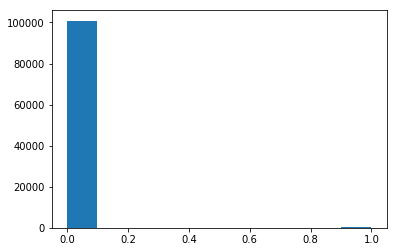

In [219]:
log_preds = logreg.predict(new_train.drop(['x'], axis=1))
plt.hist(log_preds)

In [220]:
# accuracy_score(train_y, log_preds)
roc_auc_score(train_y, logreg.predict_proba(new_train.drop(['x'], axis=1))[:,1])

0.80065331865426148

In [221]:
sum(log_preds)

568

In [222]:
new_train.head()

,x,vowels,last_pair,first_pair,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,Аалтонен,4,404,176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Аар,2,384,176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Аарон,3,946,176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ААРОН,3,946,176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Аарона,4,852,176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
%%time
clf = XGBClassifier(max_depth=20)
clf.fit(new_train.drop(['x'], axis=1), train_y)
notify('Trained!')

CPU times: user 27min 7s, sys: 19.7 s, total: 27min 26s
Wall time: 9min 5s


In [227]:
%%time
preds = clf.predict(new_train.drop(['x'], axis=1))

print(sum(train_y)/len(train_y))
print(sum(preds)/len(preds))

# it was 0.90675291890186183 with 0.87 on public leaderboard
# it was 0.95879023351214898 with 0.92 on public leaderboard
# it was 0.968493609972 with 0.92 on public leaderboard with 'length'
# it was 0.965722625434 with 0.92 on public leaderboard without 'length'
print(accuracy_score(train_y, preds))
# 0.938603843916
# 0.960742355064

0.10491282739
0.0573130325024
0.94952074787
CPU times: user 7.88 s, sys: 4.57 s, total: 12.4 s
Wall time: 11 s


In [228]:
roc_auc_score(train_y, clf.predict_proba(new_train.drop(['x'], axis=1))[:, 1])
# 0.958280574696595
# 0.98766937781938924
# got bad results only with pair_indexes and num of vowels

0.97533638311165183

In [52]:
short_indices = [en for en, x in enumerate(list(map(lambda x: len(x), test['x']))) if x == 1]

In [229]:
%%time

new_test = pd.DataFrame(columns=np.concatenate((test.columns.values, np.arange(len(ch_gram_alphabet)))))
new_test

res_test = []

for i in tqdm.tqdm(range(len(test))):
    res_test.append(np.concatenate((test.iloc[i], string_to_vec(test.iloc[i]['x'], ch_gram_alphabet))))
    
new_test = pd.DataFrame(data=res_test, columns=np.concatenate((test.columns.values, np.arange(len(ch_gram_alphabet)))))

notify('kek_2')

100%|██████████| 188920/188920 [02:38<00:00, 1191.74it/s]


CPU times: user 3min 44s, sys: 1min 12s, total: 4min 57s
Wall time: 5min 51s


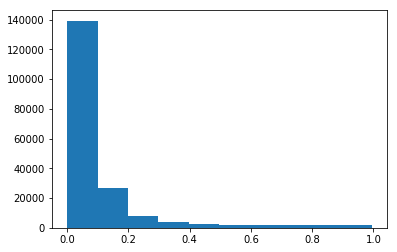

CPU times: user 14.2 s, sys: 10.1 s, total: 24.2 s
Wall time: 22.6 s


In [230]:
%%time
sample_submission['Answer'] = clf.predict_proba(new_test.drop(['x'], axis=1))[:, 1]

plt.hist(sample_submission['Answer'])
plt.show()

In [231]:
[(test.iloc[i]['x'], sample_submission.iloc[i]['Answer']) for i in [i for i, x in enumerate(sample_submission['Answer']) if x > 0.5]]

[('Абаев', 0.86535269),
 ('Абаева', 0.95711243),
 ('Абаевым', 0.9796769),
 ('абажуров', 0.56899226),
 ('АБАКУМОВ', 0.67784727),
 ('Абакумова', 0.98220736),
 ('АБАКУМОВА', 0.98220736),
 ('Абакумову', 0.94150138),
 ('Абакумовым', 0.96329576),
 ('Абалкин', 0.91022211),
 ('Абаринов', 0.8664555),
 ('Аббасова', 0.98260385),
 ('Аббасову', 0.95373493),
 ('аббат', 0.50073665),
 ('Аббат', 0.50073665),
 ('Аббе', 0.5263558),
 ('Аббот', 0.50190204),
 ('Абдрахманова', 0.93410808),
 ('Абдулина', 0.83029944),
 ('Абдуллаев', 0.71406806),
 ('Абдуллаева', 0.63174635),
 ('Абдуллаеву', 0.92194289),
 ('Абдуллаевым', 0.97028697),
 ('Абдуллина', 0.89812404),
 ('Абелева', 0.96927321),
 ('Абелевым', 0.96973002),
 ('Абердин', 0.92366761),
 ('Абердина', 0.8953231),
 ('Абердине', 0.6378653),
 ('Абердину', 0.70082355),
 ('Абидин', 0.75388163),
 ('Абидина', 0.79874724),
 ('Абиев', 0.58030319),
 ('Абиевым', 0.98285598),
 ('Абрамкин', 0.78780639),
 ('Абрамкина', 0.92522192),
 ('Абрамова', 0.9850316),
 ('Абрамовой', 0.

In [232]:
sample_submission.to_csv("submission.csv", sep=',', index=False)
notify('Done with submission!')

In [128]:
%%time
lrs = LogisticRegression()

lrs.fit(new_train.drop(['x','vowels', 'caps', 'last', 'first', 'last_pair'], axis=1), train_y)
notify('LR Trained!')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').